In [1]:
import colorsys
import glob
from IPython import display
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import time
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [ ]:
PARTICIPANT_FILE = "output/part_1.txt"

In [2]:
data = pd.read_csv(PARTICIPANT_FILE, header=None).to_numpy()
print(data.shape)

no_data = round(len(data)*0.8)
train_set = data[:no_data]
test_set = data[no_data:]
print(train_set.shape, test_set.shape)

(402, 14)
(322, 14) (80, 14)


In [3]:
anchors = train_set[:, :3]
bgcolors = train_set[:, 9:12]

positive, negative = [], []
for i in range(train_set.shape[0]):
    if data[i, 13] == 0:
        positive.append(train_set[i, 3:6])
        negative.append(train_set[i, 6:9])
    else:
        positive.append(train_set[i, 6:9])
        negative.append(train_set[i, 3:6])

positive = np.array(positive)
negative = np.array(negative)

In [4]:
anchors2 = test_set[:,:3]
bgcolors2 = test_set[:,9:12]

positive2 = []
negative2 = []
for i in range(test_set.shape[0]):
    if test_set[i, 13]==0:
        positive2.append(test_set[i, 3:6])
        negative2.append(test_set[i, 6:9])
    else:
        positive2.append(test_set[i, 6:9])
        negative2.append(test_set[i, 3:6])

positive2 = np.array(positive2)
negative2 = np.array(negative2)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = self.l1(x)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = self.l2(z)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

https://towardsdatascience.com/triplet-loss-advanced-intro-49a07b7d8905

Triplet Loss encourages that dissimilar pairs be distant from any similar pairs by at least a certain margin value. Mathematically, the loss value can be calculated as:

L = max(d(a, p) - d(a, n) + m, 0)

where:

- p, i.e., positive, is a sample that has the same label as a, i.e., anchor,
- n, i.e., negative, is another sample that has a label different from a,
- d is a function to measure the distance between these three samples,
- and m is a margin value to keep negative samples far apart.

Good e.g.:
- d(a, p) = 3
- d(a, p) = 5
- m = 1
- L = -2 -> 0

Bad e.g.:
- d(a, p) = 4.6
- d(a, p) = 4.7
- m = 1
- L = 0.9 -> 0.9

The paper uses Euclidean distance, but it is equally valid to use any other distance metric, e.g., cosine distance.

Additionally, Triplet Loss is less greedy. Unlike Contrastive Loss, it is already satisfied when different samples are easily distinguishable from similar ones. It does not change the distances in a positive cluster if there is no interference from negative examples.

In [ ]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.TripletMarginLoss(0.2)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(100000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)

### Hue

In [7]:
curve, hue = [], []
for i in range(0, 100, 1):
    (r, g, b) = colorsys.hsv_to_rgb(i/100, 1.0, 1.0)
    color = [r, g, b]
    curve.append(color)
    hue.append(i/100)
curve = torch.FloatTensor(curve)
print(curve.shape)

torch.Size([100, 3])


In [8]:
embed = model.forward(torch.FloatTensor(curve)).cpu().detach().numpy()

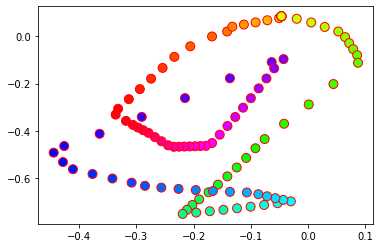

In [9]:
plt.scatter(embed[:,0], embed[:,1], c=curve, edgecolors='r', s=80)
plt.show()

In [10]:
stats.pearsonr(embed[:, 0], hue)

(-0.40072570913472527, 3.6056782646814424e-05)

In [11]:
stats.pearsonr(embed[:, 1], hue)

(-0.4541067269774295, 2.0805710187481018e-06)